In [1]:
from tqdm import tqdm
from itertools import permutations, combinations

import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch

In [14]:
SAVE_PATH = "/path/to/save/data/downstream_data_level2_H_1103.pth"

In [3]:
COLORS = ['B', 'P', 'R', 'G']
COLOR2ID = {c:ix+1 for ix, c in enumerate(COLORS)}
ID2COLOR = {ix+1:c for ix, c in enumerate(COLORS)}

In [4]:
def base_block_v5(color):
    c = COLOR2ID[color]
    arr = np.array([
        [0, 0, 0, c, c],
        [0, 0, 0, 0, 0],
        [0, c, c, 0, 0],
        [c, c, c, c, c],
        [0, 0, 0, 0, 0],
    ])
    return arr

def base_block_v6(color):
    c = COLOR2ID[color]
    arr = np.array([
        [0, c, c, 0, 0],
        [c, c, 0, 0, 0],
        [c, c, c, 0, c],
        [0, c, c, c, 0],
        [0, 0, 0, 0, 0],
    ])
    return arr

def base_block_v7(color):
    c = COLOR2ID[color]
    arr = np.array([
        [0, 0, 0, 0, 0],
        [c, 0, c, 0, c],
        [0, c, c, c, 0],
        [c, 0, c, c, 0],
        [0, 0, c, 0, 0],
    ])
    return arr

def base_block_v8(color):
    c = COLOR2ID[color]
    arr = np.array([
        [0, 0, 0, c, c],
        [c, c, c, c, 0],
        [0, c, c, 0, 0],
        [0, 0, 0, 0, 0],
        [c, c, c, 0, c],
    ])
    return arr


def base_block_v9(color):
    c = COLOR2ID[color]
    arr = np.array([
        [0, 0, 0, 0, 0],
        [c, c, c, c, 0],
        [0, c, c, c, 0],
        [0, 0, c, c, 0],
        [0, 0, c, 0, 0],
    ])
    return arr

def base_block_v10(color):
    c = COLOR2ID[color]
    arr = np.array([
        [0, 0, c, 0, 0],
        [0, 0, c, 0, 0],
        [c, c, 0, c, c],
        [0, 0, c, 0, 0],
        [0, 0, c, 0, 0],
    ])
    return arr

In [5]:
def base_block_v1(color):
    c = COLOR2ID[color]
    arr = np.array([
        [0, 0, 0, 0, 0],
        [0, c, c, 0, 0],
        [0, c, c, 0, 0],
        [c, c, c, c, c],
        [0, 0, 0, 0, 0],
    ])
    return arr

def base_block_v2(color):
    c = COLOR2ID[color]
    arr = np.array([
        [0, 0, 0, 0, 0],
        [c, c, c, c, 0],
        [c, c, c, 0, c],
        [0, c, c, c, 0],
        [0, 0, 0, 0, 0],
    ])
    return arr

def base_block_v3(color):
    c = COLOR2ID[color]
    arr = np.array([
        [0, 0, 0, 0, 0],
        [c, 0, c, 0, c],
        [0, c, c, c, c],
        [c, 0, 0, 0, c],
        [0, 0, 0, 0, 0],
    ])
    return arr

def base_block_v4(color):
    c = COLOR2ID[color]
    arr = np.array([
        [c, c, c, c, c],
        [0, 0, 0, c, 0],
        [0, 0, c, 0, 0],
        [0, 0, 0, 0, 0],
        [c, c, c, 0, c],
    ])
    return arr

In [6]:
SHAPES = ['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8']
SHAPE2FUNC = {
    'v1': base_block_v1,
    'v2': base_block_v2,
    'v3': base_block_v3,
    'v4': base_block_v4,
    'v5': base_block_v5,
    'v6': base_block_v6,
    'v7': base_block_v7,
    'v8': base_block_v8,
    'v9': base_block_v9,
    'v10': base_block_v10,
}

In [7]:
def sci_rotate(arr, angle):
    rotated_arr = ndimage.rotate(
        arr, angle, reshape=False, order=0, mode='constant', cval=0
    )
    return rotated_arr

In [8]:
def apply_change_rule(blocks, step, degree=6):
    k = step % 4
    colors, shapes, data = tuple(zip(*blocks))
    new_colors = colors[1:] + colors[:1] 
    new_shapes = shapes[-1:] + shapes[:-1]

    new_blocks = []
    for i, d in enumerate(data):
        new_d = np.copy(d)  
        new_c = new_colors[i]
        new_s = new_shapes[i]
        
        new_d = SHAPE2FUNC[new_s](new_c)
        # new_blocks.append((new_c, new_s, np.rot90(new_d, k=-k)))
        new_blocks.append((new_c, new_s, sci_rotate(new_d, angle=step * degree)))
    
    return new_blocks

def plot_sample(sample):
    plt.figure(figsize=(20, 12))

    rows, cols = 3, 20
    for i in range(rows * cols):
        if i < len(sample):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(sample[i].reshape(20, 5), cmap="RdYlBu")
            plt.axis('off')
    plt.tight_layout()  
    plt.show()

In [9]:
seq_length = 60
all_samples = []

for colors in tqdm(permutations(COLORS)):
    for shapes_combi in combinations(SHAPES, 4):
        for shapes in permutations(shapes_combi):
            sample = []
            first, second, third, fourth = [(c, s, SHAPE2FUNC[s](c)) for c, s in zip(colors, shapes)]
            for i in range(seq_length+1):
                if i > 0:
                    first, second, third, fourth = apply_change_rule([first, second, third, fourth], i, degree=360/seq_length)
                board = np.zeros((20, 5))
                board[:5, :] = first[-1]
                board[5:10, :] = second[-1]
                board[10:15, :] = third[-1]
                board[15:, :] = fourth[-1]
                sample.append(board.reshape(-1))
            all_samples.append(np.stack(sample))
len(all_samples)

24it [06:01, 15.07s/it]


40320

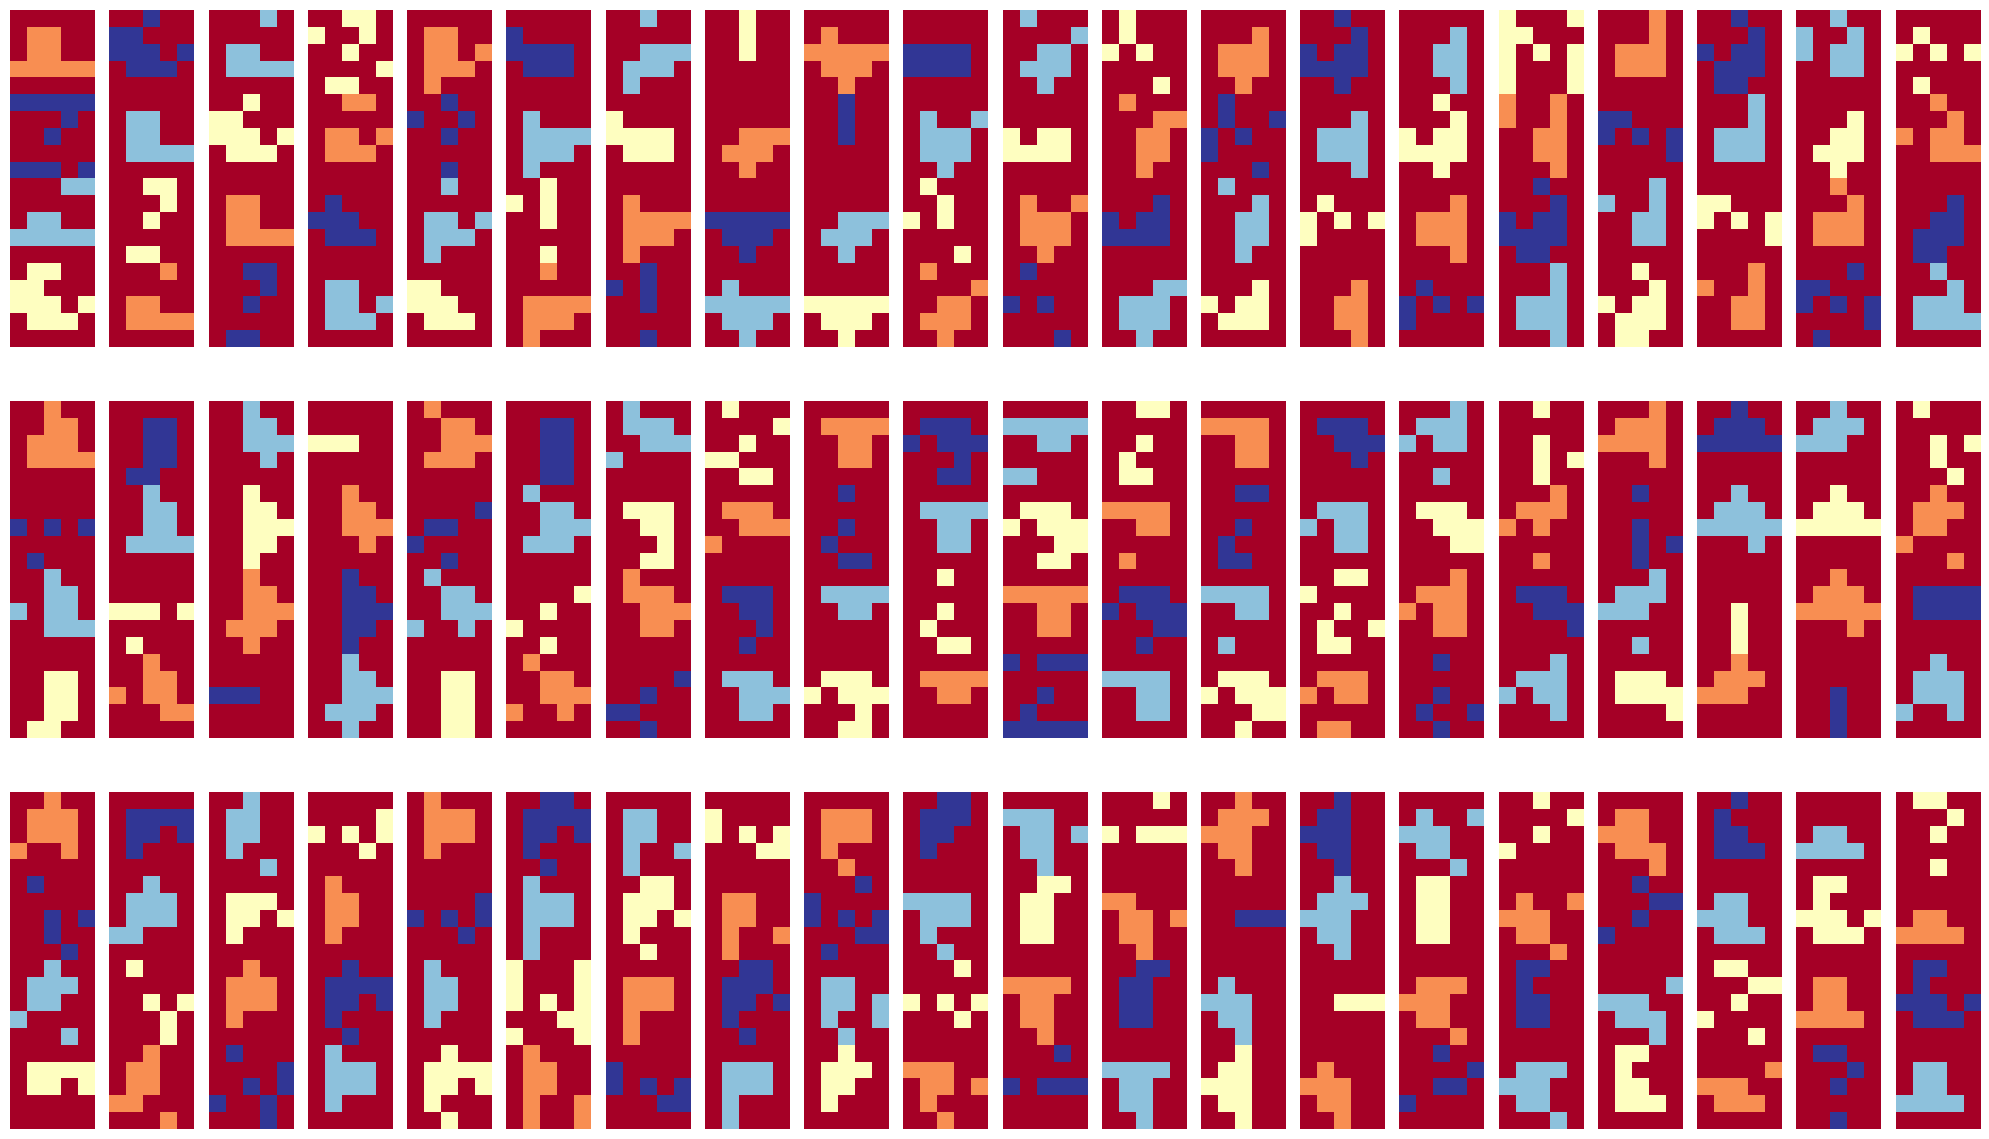

In [10]:
plot_sample(all_samples[9000])

In [11]:
train_samples, test_samples = train_test_split(all_samples, test_size=0.2, random_state=42)
len(train_samples), len(test_samples)

(32256, 8064)

In [15]:
torch.save({
    'train': torch.from_numpy(np.stack(train_samples)),
    'val': torch.from_numpy(np.stack(test_samples))
}, SAVE_PATH)